# Extra Trees Classifier (ETC) for Beta-Cell Diabetes Prediction with MDI and Gene Annotations

This notebook trains an ExtraTreesClassifier (ETC) on mouse beta-cell scRNA-seq data to classify cells as diabetic or non-diabetic, reports standard evaluation metrics (accuracy, precision/PPV, recall/sensitivity, F1-score, AUC-ROC), and computes mean decrease in impurity (MDI) to prioritize diabetes-associated genes. The top-ranked genes by MDI are then reported with functional annotations.

### Mean Decrease in Impurity (MDI)

Let $i(\cdot)$ be the node impurity (e.g., Gini or entropy).  
For feature $j$, the Mean Decrease in Impurity (MDI) computed by 
`ExtraTreesClassifier.feature_importances_` is defined as the **total decrease in impurity** 
due to splits on $j$, **weighted by the proportion of samples reaching each node**, 
and then **normalized so that $\sum_j \mathrm{MDI}_j = 1$**:

$$
\mathrm{MDI}_j
= \frac{\sum_{t=1}^{T}\;\sum_{n \in \mathcal{N}_t}
\mathbb{1}_{\{f(n)=j\}}\; p(n)\;\Delta i(n)}
{\sum_{k}\;\sum_{t=1}^{T}\;\sum_{n \in \mathcal{N}_t}
\mathbb{1}_{\{f(n)=k\}}\; p(n)\;\Delta i(n)} .
$$

with

$$
\Delta i(n) = i(n) - p_L\, i(n_L) - p_R\, i(n_R), \quad
p(n) = \tfrac{N_n}{N}, \quad
p_L = \tfrac{N_{n_L}}{N_n}, \quad
p_R = \tfrac{N_{n_R}}{N_n}.
$$

### Definitions
- $T$: number of trees in the ensemble.  
- $\mathcal{N}_t$: internal nodes of tree $t$.  
- $f(n)$: feature used at node $n$.  
- $\mathbb{1}_{\{f(n)=j\}}$: indicator that node $n$ splits on feature $j$.  
- $N$: total number of samples; $N_n$: samples reaching node $n$; $N_{n_L}, N_{n_R}$: samples in its left/right children.  
- $i(\cdot)$: impurity measure (e.g., Gini index, entropy, log loss).  

This is the definition used in [scikit-learn’s documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier.feature_importances_).


In [ ]:
# If running for the first time, uncomment to install (internet required for mygene)
#%pip install scanpy anndata scikit-learn mygene pandas numpy matplotlib

import os, sys, math, json, warnings, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import issparse
from anndata import AnnData

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import matplotlib.pyplot as plt


try:
    import mygene
    HAVE_MYG = True
except Exception as e:
    HAVE_MYG = False
    print("mygene not available; annotations will be skipped unless installed.", e)

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (6,4)


Note: you may need to restart the kernel to use updated packages.


In [2]:
# ======================== USER CONFIGURATION ========================
# Assumes this notebook is run from the `code/` directory

REPO_ROOT = Path.cwd().parent
DATA_DIR = REPO_ROOT / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

# Path to filtered atlas (generated by preprocessing notebook)
DATA_F = PROCESSED_DATA_DIR / "mouse_atlas_filtered_ML.h5ad"

# Column that contains the cell type and which value indicates beta cells
CELLTYPE_COL = "cell type"           # try one of: "cell type", "cell_type", "celltype", "celltypes"
BETA_VALUE   = "Beta"                # value that marks beta cells (case-insensitive match)

# Label column and positive class
# Default tries 'disease' (T2D vs Normal). If not found, alternatives are tried automatically.
LABEL_COL_CANDIDATES = ["disease", "condition", "status", "group"]
POSITIVE_LABELS = {"T2D", "Diabetes", "Diabetic"}       # case-insensitive membership check
NEGATIVE_LABELS = {"Normal", "Control", "Healthy"}

# Gene symbol column candidates found in `adata.var`
GENE_SYMBOL_VARS = ["gene_symbol", "gene_symbols", "gene_symbol-query", "symbol"]

# Training parameters
N_TOP_GENES_BY_VAR = 3000      # keep top-N most variable genes for training
N_ESTIMATORS = 1000            # number of trees for ETC (robust MDI)
MAX_FEATURES = "sqrt"          # feature subsampling per split
N_FOLDS = 5                    # StratifiedKFold
RANDOM_STATE = 42
N_TOP_IMPORTANT = 50           # annotate this many top genes

# --------------------------------------------------
# Sanity check
# --------------------------------------------------

assert DATA_F.exists(), f"File not found: {DATA_F}"
print(f"Using data file: {DATA_F.resolve()}")

Using data file: /Users/mdelaluz/Documents/GitHub/t2d-gene-disease-ml-prediction/data/processed/mouse_atlas_filtered_ML.h5ad


In [3]:
print("Loading AnnData...")
adata = sc.read_h5ad(DATA_F)
print("Loaded:", adata.shape, "(cells x genes)")
print("obs columns:", list(adata.obs.columns)[:20], "...")
print("var columns:", list(adata.var.columns)[:20], "...")

# ====  Build ML design-matrix X and label vector y (healthy=0, T2D=1) ====
LABEL_COL = "healthy_vs_T2D" 
assert LABEL_COL in adata.obs, f"{LABEL_COL} not found in .obs!"

#  Extract the expression matrix (dense → ~3.2 GB; OK on 32 GB RAM)
X = adata.X.toarray() if issparse(adata.X) else adata.X
print("  Matrix extracted :", X.shape)


#  Encode labels: healthy→0, T2D→1  (ignore “other” if present)
mask = adata.obs[LABEL_COL].isin(["healthy", "T2D"])
X = X[mask]

y = adata.obs[LABEL_COL][mask].map({"healthy": 0, "T2D": 1}).values

# Gene names
gene_symbol_col = next((c for c in ["gene_symbol", "gene_symbol-query", "symbol"]
                        if c in adata.var.columns), None)
genes = (adata.var[gene_symbol_col].astype(str).values
         if gene_symbol_col else adata.var_names.astype(str).values)

print("Matrix extracted :", X.shape, "(cells x genes)")
print("Labels encoded  :", np.bincount(y, minlength=2), "(healthy, T2D)")


Loading AnnData...
Loaded: (65582, 1997) (cells x genes)
obs columns: ['batch_integration', 'dataset', 'design', 'cell_cycle_phase', 'ins_high', 'gcg_high', 'sst_high', 'ppy_high', 'cell_filtering', 'strain', 'age', 'cell_type_originalDataset_unified', 'cell_type_originalDataset', 'cell_type_reannotatedIntegrated', 'n_genes', 'mt_frac', 'doublet_score', 'log10_n_counts', 'age_approxDays', 'dataset__design__sample'] ...
var columns: ['gene_symbol-query', 'used_integration-query', 'gene_symbol_original_matched-query', 'present_Fltp_2y-ref', 'present_Fltp_adult-ref', 'present_Fltp_P16-ref', 'present_NOD-ref', 'present_NOD_elimination-ref', 'present_spikein_drug-ref', 'present_embryo-ref', 'present_VSG-ref', 'present_STZ-ref', 'feature_is_filtered-ref', 'feature_name-ref', 'feature_reference-ref', 'feature_biotype-ref', 'feature_length-ref', 'feature_type-ref', 'highly_variable', 'means'] ...
  Matrix extracted : (65582, 1997)
Matrix extracted : (65582, 1997) (cells x genes)
Labels encoded

In [4]:
# --- Ensure unique gene names and select top-N most variable genes --------------
# Fallback list of candidate columns if GENE_SYMBOL_VARS was not defined earlier
if 'GENE_SYMBOL_VARS' not in globals():
    GENE_SYMBOL_VARS = ["gene_symbol", "gene_symbol-query", "symbol"]

# Re-derive 'genes' just in case GENE_SYMBOL_VARS was updated (no-op if already set)
gene_symbol_col = next((c for c in GENE_SYMBOL_VARS if c in adata.var.columns), None)
genes = (adata.var[gene_symbol_col].astype(str).values
         if gene_symbol_col else adata.var_names.astype(str).values)

# Make names unique: if duplicates exist, append the Ensembl/var index
from collections import Counter
genes = genes.astype(str)
counts = Counter(genes)
if any(v > 1 for v in counts.values()):
    ens_index = np.asarray(adata.var_names).astype(str)
    genes = np.array([f"{g}_{ens_index[i]}" if counts[g] > 1 else g
                      for i, g in enumerate(genes)], dtype=str)

# Densify X if still sparse (safety check)
if hasattr(X, "toarray"):
    X = X.toarray()

X_sel = X  # (cells x genes)
genes_sel = genes


print("Using features:", X_sel.shape, "(cells x genes) — top by variance")

Using features: (65582, 1997) (cells x genes) — top by variance


,fold,accuracy,precision,recall,f1,auc_roc
0,1,0.982008,0.995156,0.960539,0.977541,0.999226
1,2,0.981703,0.997080,0.957920,0.977108,0.999250
2,3,0.981016,0.995529,0.957733,0.976265,0.999249
3,4,0.981930,0.995347,0.960165,0.977439,0.999116
4,5,0.981854,0.997081,0.958294,0.977303,0.999303


,mean,std
accuracy,0.981702,0.000400
precision,0.996039,0.000960
recall,0.958930,0.001320
f1,0.977131,0.000511
auc_roc,0.999229,0.000069


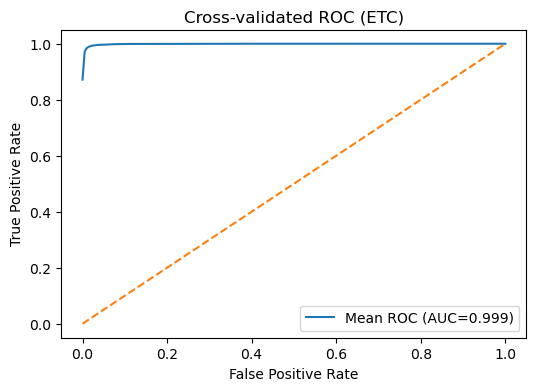

In [5]:

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

metrics_rows = []
roc_curves = []

for fold, (tr, te) in enumerate(skf.split(X_sel, y), 1):
    clf = ExtraTreesClassifier(
        n_estimators=N_ESTIMATORS,
        max_features=MAX_FEATURES,
        random_state=RANDOM_STATE + fold,
        n_jobs=-1,
        class_weight=None
    )
    clf.fit(X_sel[tr], y[tr])

    proba = clf.predict_proba(X_sel[te])[:,1]
    pred  = (proba >= 0.5).astype(int)

    acc = accuracy_score(y[te], pred)
    ppv = precision_score(y[te], pred, zero_division=0)
    rec = recall_score(y[te], pred, zero_division=0)
    f1  = f1_score(y[te], pred, zero_division=0)
    try:
        auc_ = roc_auc_score(y[te], proba)
    except Exception:
        auc_ = np.nan

    metrics_rows.append({"fold": fold, "accuracy": acc, "precision": ppv, "recall": rec, "f1": f1, "auc_roc": auc_})

    fpr, tpr, _ = roc_curve(y[te], proba)
    roc_curves.append((fpr, tpr))

metrics_df = pd.DataFrame(metrics_rows)
display(metrics_df)

mean_std = metrics_df.drop(columns=["fold"]).agg(["mean","std"]).T
display(mean_std.rename(columns={"mean":"mean", "std":"std"}))

# Plot mean ROC
xs = np.linspace(0, 1, 200)
interp_tprs = []
for fpr, tpr in roc_curves:
    interp = np.interp(xs, fpr, tpr)
    interp_tprs.append(interp)
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(xs, mean_tpr)

plt.figure()
plt.plot(xs, mean_tpr, label=f"Mean ROC (AUC={mean_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("Cross-validated ROC (ETC)")
plt.show()

In [6]:

final_clf = ExtraTreesClassifier(
    n_estimators=N_ESTIMATORS,
    max_features=MAX_FEATURES,
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_sel, y)

mdi = final_clf.feature_importances_
mdi_norm = mdi / mdi.sum()
imp_df = pd.DataFrame({
    "gene": genes_sel,
    "importance": mdi_norm
}).sort_values("importance", ascending=False).reset_index(drop=True)


### Table — Top genes by MDI with annotations

The table below includes the **Ensembl/symbol ID**, normalized **importance**, **symbol**, **gene name**, **Entrez ID**, and **GO terms** (BP and MF). Values are derived from the trained **ETC** model using **MDI**.


In [7]:

TOP = N_TOP_IMPORTANT
top_tbl = imp_df.head(TOP).copy()

if HAVE_MYG:
    mg = mygene.MyGeneInfo()

    # Detect whether genes are Ensembl IDs (ENSMUSG...) or symbols
    def looks_like_ens(s):
        s = str(s)
        return s.startswith("ENSMUSG") or s.startswith("ENSG")

    query_ids = top_tbl["gene"].astype(str).tolist()

    if any(looks_like_ens(g) for g in query_ids):
        scopes = "ensembl.gene"
    else:
        scopes = "symbol"

    FIELDS = ["symbol", "name", "entrezgene", "go.BP.term", "go.MF.term"]
    print(f"Querying MyGene (scopes='{scopes}') for", len(query_ids), "genes...")
    res = mg.querymany(query_ids, scopes=scopes, fields=FIELDS, species="mouse", as_dataframe=True, returnall=False)

    if isinstance(res, pd.DataFrame):
        ann = res.rename_axis("gene").reset_index()
    else:
        # Fallback if mygene returns list of dicts
        ann = pd.DataFrame(res).rename(columns={"query":"gene"})

    # Merge and keep relevant columns
    cols = ["gene", "symbol", "name", "entrezgene", "go.BP.term", "go.MF.term"]
    merged = top_tbl.merge(ann, on="gene", how="left")
    for c in cols:
        if c not in merged.columns:
            merged[c] = np.nan

    # Reorder columns to match the screenshot style
    merged = merged[["gene", "importance", "symbol", "name", "entrezgene", "go.BP.term", "go.MF.term"]]

    # Clean GO fields that are lists/dicts
    def _clean_go(x):
        if isinstance(x, list):
            return "; ".join(map(str, x[:5]))  # cap to avoid overly long cells
        return x

    merged["go.BP.term"] = merged["go.BP.term"].map(_clean_go)
    merged["go.MF.term"] = merged["go.MF.term"].map(_clean_go)

    display(merged.head(20))
else:
    print("mygene not installed/available — skipping annotations. Install mygene and re-run this cell.")


Input sequence provided is already in string format. No operation performed


Querying MyGene (scopes='symbol') for 50 genes...


,gene,importance,symbol,name,entrezgene,go.BP.term,go.MF.term
0,Gc,0.034740,Gc,vitamin D binding protein,14473,NaN,NaN
1,Cck,0.026394,Cck,cholecystokinin,12424,NaN,NaN
2,Ppp1r1a,0.021803,Ppp1r1a,"protein phosphatase 1, regulatory inhibitor su...",58200,NaN,NaN
3,Trpm5,0.019341,Trpm5,"transient receptor potential cation channel, s...",56843,NaN,NaN
4,Fkbp11,0.019264,Fkbp11,FK506 binding protein 11,66120,NaN,NaN
5,6330403K07Rik,0.019044,6330403K07Rik,RIKEN cDNA 6330403K07 gene,103712,NaN,NaN
6,Pam,0.018087,Pam,peptidylglycine alpha-amidating monooxygenase,18484,NaN,NaN
7,Aldh1a3,0.017780,Aldh1a3,"aldehyde dehydrogenase family 1, subfamily A3",56847,NaN,NaN
8,Dapl1,0.016753,Dapl1,death associated protein-like 1,76747,NaN,NaN
9,Cd81,0.015983,Cd81,CD81 antigen,12520,NaN,NaN


## Evaluation: Confusion Matrix and Test Scores

In [8]:
# --- Train/test split for ETC and build y_test / y_pred / y_score / T_test (hold-out test) ---

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

TEST_SIZE = globals().get("TEST_SIZE", 0.2)
RANDOM_STATE = globals().get("RANDOM_STATE", 42)

# Select dataset: prefer (X_sel, y), fallback to (X, y)
if all(name in globals() for name in ("X_sel", "y")):
    X_all_raw, y_all_raw = X_sel, y
elif all(name in globals() for name in ("X", "y")):
    X_all_raw, y_all_raw = X, y
else:
    raise NameError("Could not find (X_sel, y) or (X, y) in the environment.")

X_all = np.asarray(X_all_raw)
y_all = np.asarray(y_all_raw).ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_all
)

# Build a fresh ExtraTrees estimator for this explicit train/test split
n_estimators = int(globals().get("N_ESTIMATORS", 500))
max_features = globals().get("MAX_FEATURES", "sqrt")

test_clf = ExtraTreesClassifier(
    n_estimators=n_estimators,
    max_features=max_features,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
test_clf.fit(X_train, y_train)

y_pred = test_clf.predict(X_test)

# Probability or score for ROC/AUC
if hasattr(test_clf, "predict_proba"):
    y_score = test_clf.predict_proba(X_test)[:, 1]
else:
    try:
        dec = test_clf.decision_function(X_test)
        y_score = dec if dec.ndim == 1 else dec[:, 0]
    except Exception:
        y_score = (y_pred == 1).astype(float)

# Build T_test for score plots using PCA on X_test
pca = PCA(n_components=2)
pca.fit(X_train)
T_test = pca.transform(X_test)
best_A = T_test.shape[1]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Built y_test/y_pred/y_score with shape: {y_test.shape}, {y_pred.shape}, {y_score.shape}")
print(f"T_test shape: {T_test.shape}; best_A={best_A}")

Train shape: (52465, 1997), Test shape: (13117, 1997)
Built y_test/y_pred/y_score with shape: (13117,), (13117,), (13117,)
T_test shape: (13117, 2); best_A=2


In [9]:
# --- Build y_test / y_pred / y_score / T_test using StratifiedKFold ---
# This cell re-runs CV to harvest out-of-fold predictions and test scores.
# It supports either (X_sel, y) or (X, y) and an existing `skf`; otherwise it creates one.

def _to_np(a):
    """Return numpy array for DataFrame/Series/list/ndarray."""
    if isinstance(a, (pd.DataFrame, pd.Series)):
        return a.to_numpy()
    return np.asarray(a)

# Select dataset
if all(name in globals() for name in ("X_sel", "y")):
    X_all_raw, y_all_raw = X_sel, y
elif all(name in globals() for name in ("X", "y")):
    X_all_raw, y_all_raw = X, y
else:
    raise NameError("Could not find (X_sel, y) or (X, y) in the environment.")

X_all = _to_np(X_all_raw)
y_all = _to_np(y_all_raw).ravel()

# Choose CV splitter
if 'skf' in globals():
    splitter = skf
else:
    N_FOLDS = globals().get('N_FOLDS', 5)
    RANDOM_STATE = globals().get('RANDOM_STATE', 42)
    splitter = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Choose an estimator template
est_template = None
if 'clf' in globals():
    try:
        est_template = clone(clf)
    except Exception:
        est_template = clf
if est_template is None:
    # Fallback to ExtraTrees with common globals if available
    try:
        from sklearn.ensemble import ExtraTreesClassifier
        n_estimators = int(globals().get('N_ESTIMATORS', 500))
        max_features = globals().get('MAX_FEATURES', 'sqrt')
        random_state = int(globals().get('RANDOM_STATE', 42))
        est_template = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            random_state=random_state,
            n_jobs=-1,
        )
    except Exception as e:
        raise RuntimeError("No estimator found (no 'clf'). Please define 'clf' or install scikit-learn.")

y_true_all, y_pred_all, y_score_all, T_list = [], [], [], []
max_components_seen = 0

for fold, (tr, te) in enumerate(splitter.split(X_all, y_all), 1):
    # Clone estimator each fold when possible
    try:
        est = clone(est_template)
    except Exception:
        # Last-resort: re-use template (may retain state; not ideal but better than failing)
        est = est_template

    X_tr, X_te = X_all[tr], X_all[te]
    y_tr, y_te = y_all[tr], y_all[te]

    est.fit(X_tr, y_tr)
    y_pred_fold = est.predict(X_te)

    # Probability/decision scores (useful for ROC/AUC)
    if hasattr(est, 'predict_proba'):
        proba = est.predict_proba(X_te)
        if proba.ndim == 2 and proba.shape[1] > 1:
            score1 = proba[:, 1]
        else:
            score1 = proba.ravel()
    elif hasattr(est, 'decision_function'):
        dec = est.decision_function(X_te)
        score1 = dec if dec.ndim == 1 else dec[:, 0]
    else:
        # Fallback: map predicted label == 1 to {0,1}
        try:
            score1 = (y_pred_fold == 1).astype(float)
        except Exception:
            score1 = np.zeros_like(y_pred_fold, dtype=float)

    # Build test "scores" for visualization
    T_fold = None
    if hasattr(est, 'transform'):
        try:
            T_tmp = est.transform(X_te)
            T_fold = T_tmp if T_tmp.ndim > 1 else T_tmp.reshape(-1, 1)
        except Exception:
            T_fold = None
    if T_fold is None:
        # PCA fallback to get 2 components
        pca = PCA(n_components=2)
        pca.fit(X_tr)
        T_fold = pca.transform(X_te)

    max_components_seen = max(max_components_seen, T_fold.shape[1])
    y_true_all.append(y_te)
    y_pred_all.append(y_pred_fold)
    y_score_all.append(score1)
    T_list.append(T_fold)

# Concatenate across folds
y_test = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)
y_score = np.concatenate(y_score_all)

# Harmonize T_test to a consistent number of components across folds
A_final = min(2, max_components_seen) if max_components_seen >= 1 else 1
T_test = np.vstack([T[:, :A_final] if T.shape[1] >= A_final else np.pad(T, ((0,0),(0, A_final - T.shape[1])), mode='constant') for T in T_list])
best_A = A_final

print(f"Built y_test/y_pred/y_score with shape: {y_test.shape}, {y_pred.shape}, {y_score.shape}")
print(f"T_test shape: {T_test.shape}; best_A={best_A}")


Built y_test/y_pred/y_score with shape: (65582,), (65582,), (65582,)
T_test shape: (65582, 2); best_A=2


In [10]:
# --- Helper: infer y_test and y_pred from common variables ---

def _as_np(x):
    """Return a 1D numpy array from Series/ndarray/list."""
    if isinstance(x, pd.DataFrame):
        return x.values.ravel()
    if isinstance(x, pd.Series):
        return x.values
    arr = np.asarray(x)
    return arr

# Try to define y_test if missing
if 'y_test' not in globals():
    # Option A: from global y and a test index variable
    if 'y' in globals():
        for idx_name in ('test_idx', 'test_index', 'te', 'idx_test'):
            if idx_name in globals():
                y_test = _as_np(globals()['y'])[globals()[idx_name]]
                break
    
    # Option B: align by pandas index if X and X_test are DataFrames
    if 'y_test' not in globals():
        if all(name in globals() for name in ('X', 'X_test', 'y')):
            if hasattr(X, 'index') and hasattr(X_test, 'index'):
                y_series = globals()['y'] if isinstance(globals()['y'], pd.Series) else pd.Series(_as_np(globals()['y']), index=X.index)
                try:
                    y_test = y_series.loc[X_test.index].to_numpy()
                except Exception:
                    pass

    # Option C: common alternative variable names
    if 'y_test' not in globals():
        for alt in ('y_valid', 'y_val', 'y_holdout', 'y_te'):
            if alt in globals():
                y_test = _as_np(globals()[alt])
                break

# Try to define y_pred if missing
if 'y_pred' not in globals():
    if 'clf' in globals() and 'X_test' in globals():
        try:
            y_pred = clf.predict(X_test)
        except Exception:
            pass
    if 'y_pred' not in globals():
        for alt in ('y_pred_cv', 'y_hat', 'y_hat_test', 'pred_test'):
            if alt in globals():
                y_pred = _as_np(globals()[alt])
                break

# Final check
if 'y_test' not in globals() or 'y_pred' not in globals():
    raise NameError(
        "Could not infer 'y_test' and/or 'y_pred'. "
        "Please define them explicitly. Examples: "
        "(1) If you used train_test_split: y_test = ...; y_pred = clf.predict(X_test). "
        "(2) If you used StratifiedKFold, concatenate fold-wise test labels into 'y_test' and predictions into 'y_pred'."
    )


,pred healthy,pred T2D
healthy (0),38744,103
T2D (1),1101,25634


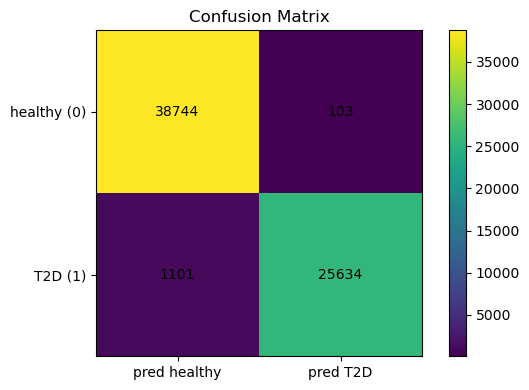

In [11]:
# Confusion matrix

# y_test and y_pred must exist at this point (see helper cell above)
y_test_arr = np.asarray(y_test)
y_pred_arr = np.asarray(y_pred)

# Determine label order (binary 0/1 or generic)
labels_list = sorted(list(pd.unique(np.concatenate([y_test_arr, y_pred_arr]))))
cm = confusion_matrix(y_test_arr, y_pred_arr, labels=labels_list)

# Friendly names: map 0->healthy, 1->T2D if binary; otherwise echo label values
row_names = []
col_names = []
for lab in labels_list:
    if lab == 0:
        row_names.append("healthy (0)")
        col_names.append("pred healthy")
    elif lab == 1:
        row_names.append("T2D (1)")
        col_names.append("pred T2D")
    else:
        row_names.append(str(lab))
        col_names.append(f"pred {lab}")

cm_df = pd.DataFrame(cm, index=row_names, columns=col_names)
display(cm_df)

# Plot confusion matrix with annotations
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.xticks(range(len(labels_list)), col_names, rotation=0)
plt.yticks(range(len(labels_list)), row_names)
plt.title("Confusion Matrix")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


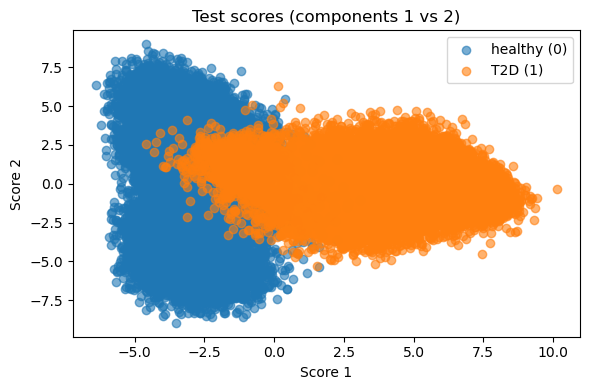

In [12]:
# --- Test score plots ---

if 'T_test' not in globals():
    raise NameError("T_test is not defined. Provide the test scores matrix in 'T_test' (shape: n_samples x n_components).")

# If best_A is not defined, infer number of components from T_test
if 'best_A' not in globals():
    best_A = T_test.shape[1]

y_test_arr = np.asarray(y_test)

if best_A >= 2:
    plt.figure()
    plt.scatter(T_test[y_test_arr == 0, 0], T_test[y_test_arr == 0, 1], alpha=0.6, label="healthy (0)")
    plt.scatter(T_test[y_test_arr == 1, 0], T_test[y_test_arr == 1, 1], alpha=0.6, label="T2D (1)")
    plt.xlabel("Score 1")
    plt.ylabel("Score 2")
    plt.title("Test scores (components 1 vs 2)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    plt.figure()
    plt.hist(T_test[y_test_arr == 0, 0], bins=30, alpha=0.6, label="healthy (0)")
    plt.hist(T_test[y_test_arr == 1, 0], bins=30, alpha=0.6, label="T2D (1)")
    plt.xlabel("Score 1")
    plt.ylabel("Count")
    plt.title("Test scores (component 1)")
    plt.legend()
    plt.tight_layout()
    plt.show()
